# Data

In the cell below, we obtain a signal of the system $y(k) = 0.1y(k-1) - 0.5u(k-1)y(k-1) + 0.1u(k-2)$. You can change it as you wish, or use your own data collected elsewhere. The data must be in column format. It is also possible to use in the same identification process different data acquisitions from the same system. Each data acquisition must be in a different column and the columns from the input matrix must be correspondent to the columns from the output matrix

In [36]:

Fs = 100; % Sampling frequency of the data acquisition, in Hz.


u = randn(2000, 1);
y = 0.0*ones(size(u));
t = (1:length(y))/Fs;

for k = 5:length(y)
   y(k) = 0.1*y(k-1) - 0.5*u(k-1)*y(k-1) + 0.1*u(k-2); 
end


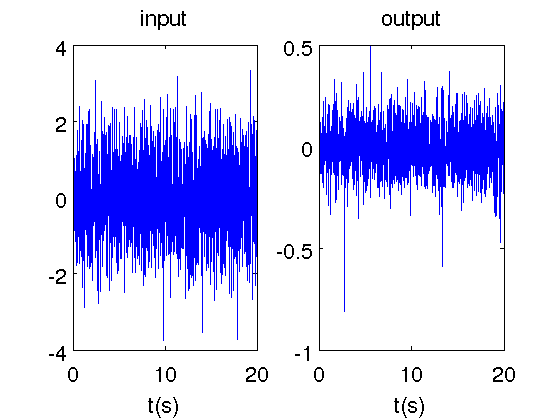

In [37]:
subplot(1,2,1);plot(t, u); title('input'); xlabel('t(s)')
subplot(1,2,2);plot(t, y); title('output');  xlabel('t(s)')


## Prepare the data

Here we throw away the first 100 samples to avoid transient effects. This prepare could also involve some kind of normalization.

In [38]:
input = u(100:end);   
output = y(100:end);  

# Identification Process

$\require{dsfont}$
The model structure that we use to identify the nonlinear  system is called as NARMAX and has the following structure:

$
\begin{equation}
y(k) = F\left[y(k-1), y(k-2),..., y(k-m_y), u(k-d), ..., u(k-d-m_u), \xi(k-1), ..., \xi(k-m_\xi) \right]  
\end{equation}
$

where $u$ is the input signal, $y$ is the output signal and $\xi$ is the residue signal. The format of the NARMAX model used is the polynomial form:

$
\begin{equation}
  y(k) = \beta_0 + \sum\limits_{i_1=1}^n\beta_{i_1}x_{i_1}(k) + \sum\limits_{i_1=1}^n\sum\limits_{i_2=i_1}^n\beta_{i_1i_2}x_{i_1}(k)x_{i_2}(k)+...+\sum\limits_{i_1=1}^n...\sum\limits_{i_l=i_{l-1}}^n\beta_{i_1i_2... i_l}x_{i_1}x_{i_2}... x_{i_l} + \xi(k)
\end{equation}
$
with

$
\begin{equation}
x_m(k)=\left\{ \begin{array}{l l}
u(k-m) & 1\leqslant m \leqslant m_u\\
y(k-(m - m_u)) & m_u+1\leqslant m \leqslant m_u + m_y\\
\xi(k - (m - m_u - m_y)) & m_u+m_y+1 \leqslant m \leqslant m_u+m_y+m_\xi
\end{array}\right.  
\end{equation}
$

where $m_u$ is the number of input  past values to be considered in the model search, $m_y$ is the number of output  past values to be considered in the model search, $m_\xi$ is the number of the residue past values to be considered in the model search and $l$ is the maximal polynomial degree to be considered to form the combinations between the signals $u$, $y$ e $\xi$.

Calling each combination $x_{i_1}x_{i_2}... x_{i_l}$ as $p_i$, the Equation above can be rewritten as:

$
\begin{equation}
  y(k) = \sum\limits_{i=1}^M \beta_ip_i(k) + \xi(k)
\end{equation}
$

where $M$ is the number of combinations used in the model search. In matricial form, the equation above is:

$
\begin{equation}
  Y = PB+\xi 
\end{equation}
$

where:

$
\begin{align}
  Y&=\left[y(1),y(2), ..., y(N)\right]^T\\
  B &= \left[\beta_1, \beta_2, ..., \beta_M \right]^T\\
  \xi&=\left[\xi(1), \xi(2), ..., \xi(N) \right]^T\\
  P = \left[p_1,p_2,..., p_M\right] &= \left[\begin{array}{cccc}
  p_1(1)&p_2(1)&...&p_M(1)\\
  \vdots&\vdots&\ddots&\vdots\\
  p_1(k)&p_2(k)&...&p_M(k)\\
  \vdots&\vdots&\ddots&\vdots\\
  p_1(N)&p_2(N)&...&p_M(N)
  \end{array}\right]  
\end{align}
$

where $^T$ stand for the matrix or vector transponse.

## Parameters of the identification process

For the identification of the system described at the begin of this notebook we use the parameters in the cell bellow. As in this demonstration of the FROLS method we know our system, the used parameters are exactly what we need,  but normally we do not know what parameters to use! Normally, to find these parameters, we need to try some values before finding the right ones. If you use $m_u, m_y$ and $m_\xi$ values higher than necessary, the algorithm will work but the time of processing will be longer. Try to modify the parameters below to see what happens.

In [39]:
mu = 2; 
my = 1; 
me = max(mu,my); 
degree = 2; 
delay = 1; 

In [40]:
dataLength = 500; % number of samplings to be used during the identification process. Normally a number between 400 and
% 600 is good. Do not use large numbers.
pho = 1e-2; % a lower value will give you more identified terms. A higher value will give you less.
phoN = 1e-1; % a lower value will give you more identified terms. A higher value will give you less.
delta = 1e-1; 

## Build the P matrix

In [41]:
numberOfCandidates = round(findPMatrixSize(mu - delay + 1, my, degree));
begin = randi([1 length(input) - dataLength - 1], 1);
u = input(begin+1:begin + dataLength);
y = output(begin+1:begin + dataLength);
[p, D]= buildPMatrix(u, y, degree, mu, my, delay);
y = y(max(mu,my) + 1:end);

The terms that the FROLS algorithm will use to try to find the model are:

In [42]:
disp(D)

Columns 1 through 6

    '1'    'u(k-1)'    'u(k-2)'    'y(k-1)'    'u(k-1)u(k-1)'    'u(k-1)u(k-2)'

  Columns 7 through 10

    'u(k-1)y(k-1)'    'u(k-2)u(k-2)'    'u(k-2)y(k-1)'    'y(k-1)y(k-1)'

The first 15 lines of the P matrix are:

In [43]:
disp(p(1:15,:))

Columns 1 through 7

    1.0000    0.2887   -1.5348    0.1715    0.0833   -0.4431    0.0495
    1.0000   -0.0682    0.2887   -0.1611    0.0046   -0.0197    0.0110
    1.0000    0.2884   -0.0682    0.0073    0.0832   -0.0197    0.0021
    1.0000   -0.8051    0.2884   -0.0071    0.6481   -0.2322    0.0057
    1.0000   -1.8270   -0.8051    0.0253    3.3379    1.4709   -0.0461
    1.0000   -1.0724   -1.8270   -0.0549    1.1501    1.9593    0.0589
    1.0000    1.8749   -1.0724   -0.2176    3.5152   -2.0107   -0.4080
    1.0000   -0.1297    1.8749    0.0750    0.0168   -0.2432   -0.0097
    1.0000   -0.9515   -0.1297    0.1999    0.9054    0.1234   -0.1902
    1.0000    1.4679   -0.9515    0.1021    2.1546   -1.3967    0.1499
    1.0000    0.9190    1.4679   -0.1599    0.8445    1.3489   -0.1469
    1.0000   -0.8626    0.9190    0.2043    0.7441   -0.7927   -0.1762
    1.0000    1.0750   -0.8626    0.2004    1.1555   -0.9272    0.2154
    1.0000    1.1104    1.0750   -0.1739    1.2330    1.

## The system identification

In [44]:
global l q g err A ESR M0;
q = []; err=[]; A=[]; g=[]; 
s = 1;
ESR = 1;
M = size(p, 3);
l = zeros(1, M);

### The function that implements the FROLS algorithm is written below, with brief explanations about some parts inserted in the code. Actually this function can handle more than one data collection of the same system (that is the reason of the m in mfrols), but in this notebook we will not use multiple trials. Just ignore the outside loop and the variable j.

function beta = mfrols(p, y, pho, s)
    
    global l;
    global err ESR;
    global A;
    global q g M0;
    beta = [];
    M = size(p,2);
    L = size(p,3);
    gs=zeros(L,M);
    ERR=zeros(L,M);
    qs=zeros(size(p));
    
    for j=1:L
        sigma = y(:,j)'*y(:,j);
        
        for m=1:M
            if (max(m*ones(size(l))==l)==0)
            

$\text{The Gram-Schmidt method was implemented in a modified way, as shown in Rice, JR(1966)}$

$\text{For each } m, \text{ we compute: } \\
qs_m = p_m - \sum\limits_{r=1}^{s-1}\frac{q_r^Tqs_m}{q_r^Tq_r}q_r$
                 
                 qs(:,m,j) = p(:,m,j);
                 for r=1:s-1
                     qs(:,m,j) = qs(:,m,j) - (squeeze(q(:,r,j))'*qs(:,m,j))/...
                         (squeeze(q(:,r,j))'*squeeze(q(:,r,j)))*squeeze(q(:,r,j));
                 end

 
$\text{We compute for each candidate that was not chosen:}$

$gs_m = \frac{y^Tqs_m}{qs_m^Tqs_m}\\
\text{ERR}_m = gs_m^2\frac{qs_m^Tqs}{y^Ty}$

                gs(j,m) = (y(:,j)'*squeeze(qs(:,m,j)))/(squeeze(qs(:,m,j))'*squeeze(qs(:,m,j)));
                ERR(j,m) = (gs(j,m)^2)*(squeeze(qs(:,m,j))'*squeeze(qs(:,m,j)))/sigma;
            else
                ERR(j,m)=0;
            end
        end 
    end

    
$\text{And here we chose to be part of the model the candidate term with the highest ERR.}$

    ERR_m = mean(ERR, 1);
    l(s) = find(ERR_m == max(ERR_m), 1);
    err(s) = ERR_m(l(s));
    for j=1:L

$\text{After the model term has been chosen we compute the values of the matrix } A$


$a_{r,s} = \frac{q_r^Tp_{\text{chosen term}}}{q_r^Tq_r}, 1 \leqslant r \leqslant s - 1\\
a_{s,s} = 1$

        for r = 1:s-1
            A(r, s, j) = (q(:,r,j)'*p(:,l(s),j))/(q(:,r,j)'*q(:,r,j));    
        end
        A(s, s, j) = 1;
        q(:, s,j) = qs(:,l(s),j);
        g(j,s) = gs(j,l(s));
    end    

    
$\text{After this process the matrix } A \text{ will have the format: }\\
A=\left[\begin{array}{cccc}
  1&a_{12}&...&a_{1s}\\
  0&1&...&a_{2s}\\
  \vdots&\vdots&\ddots&\vdots\\
  0&...&1&a_{s-1,s}\\
  0&0&...&1  \end{array} \right]$

    

  ESR = ESR - err(s);  
  
$\text{The stop criterium is based on the ERR value of the chosen term. If it is lower than } \rho,\text{ the process of search for terms stops.}$
    
    if (err(s) >= pho && s < M)
       s = s + 1; 
       clear qs 
       clear gs
       
 

      
$\text{Here is the recurrent call of the frols algorithm.}$

       beta = mfrols(p, y, pho, s);
    else
       M0 = s;
       s = s + 1;
       for j=1:L

$\text{ At the end, we compute the coefficients } \beta \text{ of each term by doing:}\\
B = A^{-1}g$

            beta(:,j) = A(:,:,j)\g(j,:)';
       end       
    end   
end

In [45]:
beta = mfrols(p, y, pho, s);
la = l(1:M0)';
Da = D(la)';

In [46]:
[Dn, an, ln] = NARXNoiseModelIdentification(input, output, degree, mu, my, me, delay, dataLength, 1, phoN,  ...
        beta, la);

In [47]:
[a, an, xi] = NARMAXCompleteIdentification(input, output, Da, Dn, dataLength, ...
        1,  delta, degree, degree);

## Identified Model

In [48]:
for i = 1:length(Da)
    disp({Da{i}, num2str(a(i))}) 
end

'u(k-2)'    '0.1'

    'u(k-1)y(k-1)'    '-0.5'

    'y(k-1)'    '0.1'

Note that the found terms should be the same of the system difference equation on the top of this notebook.

# Generalized Frequency Response Function (GFRF)

If your identified system has terms with inputs and outputs, the GFRF will be non-null for 
degrees higher than the maximal polynomial degree. In this case, a good number
is to add one to your maximal polynomial degree. If you have only
inputs or outputs terms, the GFRFdegree will be the maximal
polynomial degree.

In [49]:
GFRFdegree = 3;

In [50]:
Hn = computeSignalsGFRF(Da, Fs, a, GFRFdegree);

In [51]:
for j = 1:GFRFdegree
        disp(['GFRF of order ' num2str(j) ': '])
        pretty(Hn{j})
end

GFRF of order 1: 

            /   pi f1 i \
         exp| - ------- |
            \     25    /
  - ---------------------------
       /    /   pi f1 i \     \
       | exp| - ------- |     |
       |    \     50    /     |
    10 | ---------------- - 1 |
       \        10            /
GFRF of order 2: 

             /   pi f1 i \    /   pi f1 i \    /   pi f2 i \
          exp| - ------- | exp| - ------- | exp| - ------- |
             \     25    /    \     50    /    \     50    /
  - --------------------------------------------------------------
       /    /   pi f1 i \     \ /    /   pi f1 i   pi f2 i \     \
       | exp| - ------- |     | | exp| - ------- - ------- |     |
       |    \     50    /     | |    \     50        50    /     |
    20 | ---------------- - 1 | | -------------------------- - 1 |
       \        10            / \             10                 /
GFRF of order 3: 

    /    /   pi f1 i \                      /   pi f3 i \                \
  - | exp| - 

# Nonlinear Output Frequency Response Function (NOFRF)

The frequency components of the output signal $y$ of a system to a given input $u$ is:

$Y(j\omega) = \sum\limits_{n=1}^N Y_n(j\omega)$

where:

$Y_n(j\omega)=\frac{1/\sqrt{n}}{(2\pi)^{n-1}}\int\limits_{\omega=\omega_1+...+\omega_n}H_n(j\omega,...,j\omega_n)\prod\limits_{i=1}^nU(j\omega_i)d\sigma_{\omega n}$ 